In [1]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
from sklearn import metrics
from statistics import median

In [3]:
%run -i '/home/ml/Documents/ladderwalk/functions.py'

In [7]:
f = '/home/ml/Documents/Not_TADSS_Videos/MC30/cut/dlc_output_resnet50/MC30_12-04-2019_L4_crossing8_patternA_light2_DLC_resnet50_LadderWalkFeb13shuffle1_450000.h5'

In [8]:
df = pd.read_hdf(f)
name=f.split("/")[8]
run = name.split("_")[2]
subject = name.split("_")[0]
date = name.split("_")[1]
crossing=name.split("_")[3][-1]
likelihood_threshold = 0.1
xheight = 20
xdist = 4
yheight = 5
ydist = 4
zero_threshold = 5

path = f.split(".")[0].split("/")[:-2]+["dlc_output_rungs"]
rung_folder = os.path.join(*(path))
rung_file= f.split(".")[0].split("/")[-1].split("_")[0]+"_"+f.split(".")[0].split("/")[-1].split("_")[1]+"_"+f.split(".")[0].split("/")[-1].split("_")[2]+"_"+f.split(".")[0].split("/")[-1].split("_")[3]+"_"+f.split(".")[0].split("/")[-1].split("_")[4]+"_"+f.split(".")[0].split("/")[-1].split("_")[5]
#read the file with the rung data
rung_df = pd.read_hdf("/"+rung_folder+"/"+rung_file+"_"+"DLC_resnet50_LadderWalkMar12shuffle1_350000.h5")
rung_df = rung_df['DLC_resnet50_LadderWalkMar12shuffle1_350000']
rung_list = []
for i in range(1,63):
    rung_list.append("rung_"+str(i))
for rung in rung_list:
    rung_df[rung]=likelihood_filter(rung_df[rung],0.8)
rung_mean = rung_df.agg(["mean","sem"])
rung_x = np.empty(shape=(63,1))
rung_y = np.empty(shape=(63,1))
for rung in rung_list:
    num = int(rung.split("_")[-1])
    rung_x[num]=rung_mean[rung]["x"]["mean"]
    rung_y[num]=rung_mean[rung]["y"]["mean"]

rung_x = rung_x[~np.isnan(rung_x)]
rung_y = rung_y[~np.isnan(rung_y)]
rung_x = rung_x[not_outliers(rung_y)]
rung_y = rung_y[not_outliers(rung_y)]

/home/ml/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/ml/Documents/ladderwalk/functions.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['likelihood']<=threshold] = np.nan


In [10]:
front = extract_limbs(df,'DLC_resnet50_LadderWalkFeb13shuffle1_450000','left fingers')

In [11]:
front = likelihood_filter(front,0.1)

In [32]:
db = DBSCAN(eps=5, min_samples = 3).fit(front)

In [33]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [34]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [35]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 7
Estimated number of noise points: 20


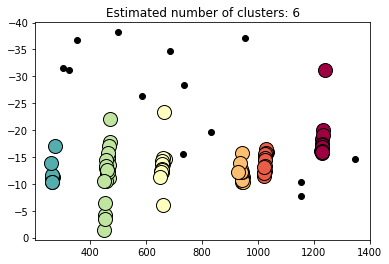

In [16]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = front[class_member_mask & core_samples_mask]
    plt.plot(xy['x'], xy['y'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = front[class_member_mask & ~core_samples_mask]
    plt.plot(xy['x'], xy['y'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
plt.gca().invert_yaxis()

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [17]:
cluster_center = []
for k in unique_labels:
    class_member_mask = (labels == k)
    if len(front[class_member_mask & core_samples_mask].index)>1:
        center = round(median(list(front[class_member_mask & core_samples_mask].index)),0)
        cluster_center.append(center)
    else:
        continue
cluster_center 

[6.0, 21, 34, 52.0, 76.0, 98]

In [258]:
cluster_center = []
for k in unique_labels:
    class_member_mask = (labels == k)
    if len(front[class_member_mask & core_samples_mask].index)>1:
        center = round(median(list(front[class_member_mask & core_samples_mask].index)),0)
        cluster_center.append(center)
    else:
        continue
cluster_center 

[8.0, 21, 33, 40, 52.0, 77, 98]

In [27]:
cluster_y = []
for k in unique_labels:
    class_member_mask = (labels == k)
    if len(front[class_member_mask & core_samples_mask].index)>1:
        center_y = median(list(front['y'][class_member_mask & core_samples_mask]))
        cluster_y.append(center_y)
    else:
        continue
[x for x in cluster_y if x >0]

[-17.06477314405413,
 -14.506024878274275,
 -12.110760197462469,
 -12.650499381370082,
 -12.574833590462731,
 -11.307430743240388]

In [21]:
front

,x,y,likelihood
0,1347.072266,-14.535125,0.997783
1,1240.979004,-31.262614,0.917808
2,1226.119507,-16.187799,0.973392
3,1230.784912,-16.877798,0.989038
4,1228.861694,-18.283430,0.977122
...,...,...,...
97,261.656982,-11.118345,0.998047
98,261.029602,-11.651563,0.997018
99,261.554749,-10.370472,0.996413
100,262.452881,-10.309792,0.991030


In [259]:
for k in unique_labels:
    class_member_mask = (labels == k)
    if len(front[class_member_mask & core_samples_mask].index)>1:
        print(median(front[class_member_mask & core_samples_mask].index))

7.5
21
33
40
51.5
77
98


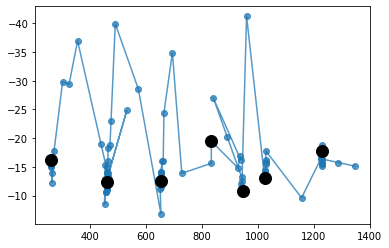

In [271]:
plt.plot(front['x'],front['y'],marker='o',alpha=0.75)
plt.plot(front['x'][cluster_center],front['y'][cluster_center],color='k',markersize=12,marker='o',lw=0)
plt.gca().invert_yaxis()